In [118]:
from pandas import read_csv, concat
data = read_csv('../../data/dt.consecutive.csv', iterator=True, chunksize=1000000)
data = concat(chunk[chunk['MAC'] == 'd4:c9:4b:c4:bd:6a'] for chunk in data)

In [122]:
data = data[data['time'].dt.month < 3]

In [123]:
len(data)

720

In [121]:
data.drop('Unnamed: 0', axis=1, inplace=True)
from datetime import datetime

def format(time):
    return datetime.strptime(time, '%Y-%m-%d %H:%M:%S')

data['time'] = [format(time) for time in data['time']]

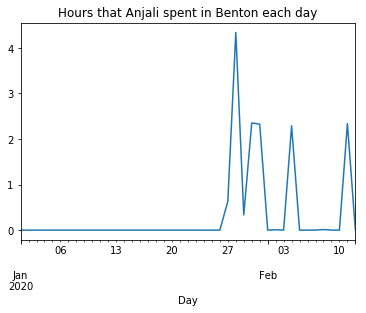

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas import date_range

def cal(day):
    current = 0
    prev = 0
    sum = 0
    for probe in day['time']:
        prev = current
        current = probe
        if prev != 0:
            diff = (current - prev).seconds
            if diff < 600:
                sum += diff
            else:
                sum+= 600
    return sum / 3600

range = date_range('01-01-2020', '02-12-2020')

data2 = data.groupby(data['time'].dt.floor('d')).apply(cal)
data2 = data2.reindex(range, fill_value=0)
graph = data2.plot(title = 'Hours that Anjali spent in Benton each day')
graph.set_xlabel('Day')
plt.savefig('Anjali2.jpg', dpi=1200, bbox_inches = 'tight')

In [70]:
a = data.groupby(data['time'].dt.floor('d')).apply(cal)

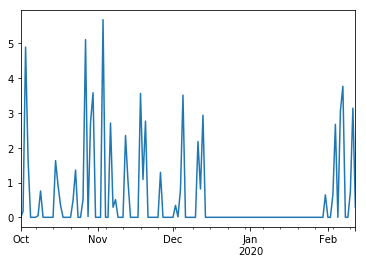

In [81]:
from pandas import date_range

idx = date_range('10-01-2019', '02-12-2020')
a.reindex(idx, fill_value=0).plot()